In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import xarray as xr
import matplotlib.pyplot as plt

In [5]:
el_path_main = Path(os.getcwd()).parent
el_path_main

WindowsPath('e:/backup Asus G15 27_10_2021/Colegio de Mates Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting')

In [6]:
el_path_main/'2. Datos/Main gridded data'
# .gz es porque es un comprimido
# los .dat son un archivo complicado de leer ya que tenemos que hacer un reshape al array creado en función a la lat, long, tiempo, etc.
# los .dat.nc son más sencillo de leer

WindowsPath('e:/backup Asus G15 27_10_2021/Colegio de Mates Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/2. Datos/Main gridded data')

In [ ]:
import gzip
import shutil

# Decompress .gz file
sufix = 'dat'

lista_info_files = ['cld', # Cloud Coverage (%)
                    'dtr', # Diurnal 2 m temperature range (degrees Celsius)
                    'frs', # Frost days (days per month)
                    'pet', # Potential evapo-transpiration (mm/day)
                    'pre', # Precipitation rate (mm/month )
                    'tmn', # Minimum 2 m temperature (degrees celsius)
                    'tmp', # Mean 2 m temperature (degrees celsius)
                    'tmx', # Maximum 2 m temperature (degrees celsius)
                    'vap', # Vapour pressure (hPa)
                    'wet'  # Wet days (days)
                    ]
for file_info in lista_info_files:
    file_name_ini = el_path_main/f'2. Datos/Main gridded data/cru_ts4.09.1901.2024.{file_info}.{sufix}.nc.gz' 
    file_name_end = el_path_main/f'2. Datos/Main gridded data/cru_ts4.09.1901.2024.{file_info}.{sufix}.nc'
    with gzip.open(file_name_ini, 'rb') as f_in:
        with open(file_name_end, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)



In [ ]:
files_cargados = {}
for file_info in lista_info_files:
    file_name_nc = el_path_main/f'2. Datos/Main gridded data/cru_ts4.09.1901.2024.{file_info}.dat.nc'
    # Load the dataset
    ds = xr.open_dataset(file_name_nc)
    files_cargados[f'ds_{file_info}'] = ds

C:\Users\Gabri\AppData\Local\Temp\ipykernel_33688\2219173767.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_name_nc)
C:\Users\Gabri\AppData\Local\Temp\ipykernel_33688\2219173767.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_name_nc)


In [ ]:
ds_cld = files_cargados['ds_cld']

In [ ]:
ds_cld['lat'].values.shape, ds_cld['lon'].values.shape, ds_cld['time'].values.shape, ds_cld['cld'].values.shape

((360,), (720,), (1488,), (1488, 360, 720))

In [ ]:
_lon, _lat = np.meshgrid(ds_cld['lon'].values, ds_cld['lat'].values)

(360, 720)

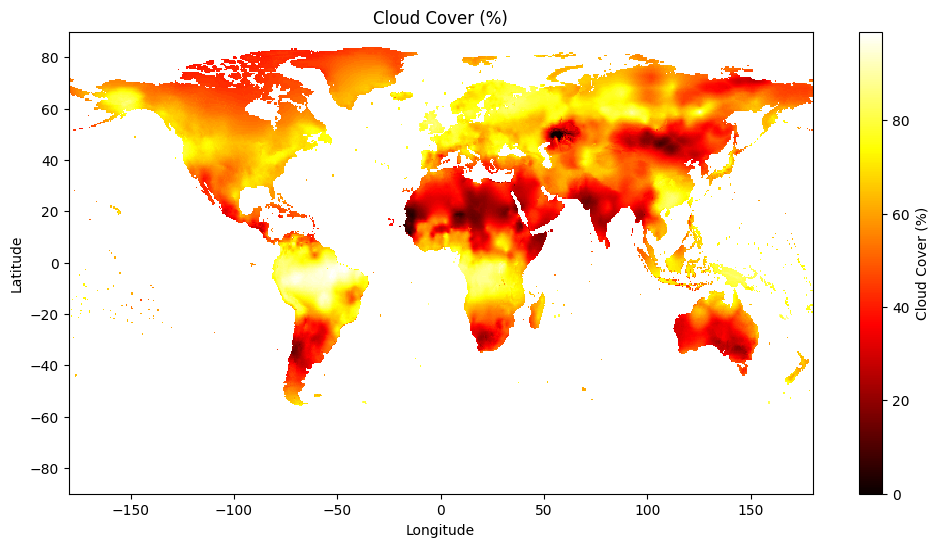

In [ ]:
_cld = ds_cld['cld'].values[-10]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, _cld, shading='auto', cmap='hot')
plt.colorbar(label='Cloud Cover (%)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

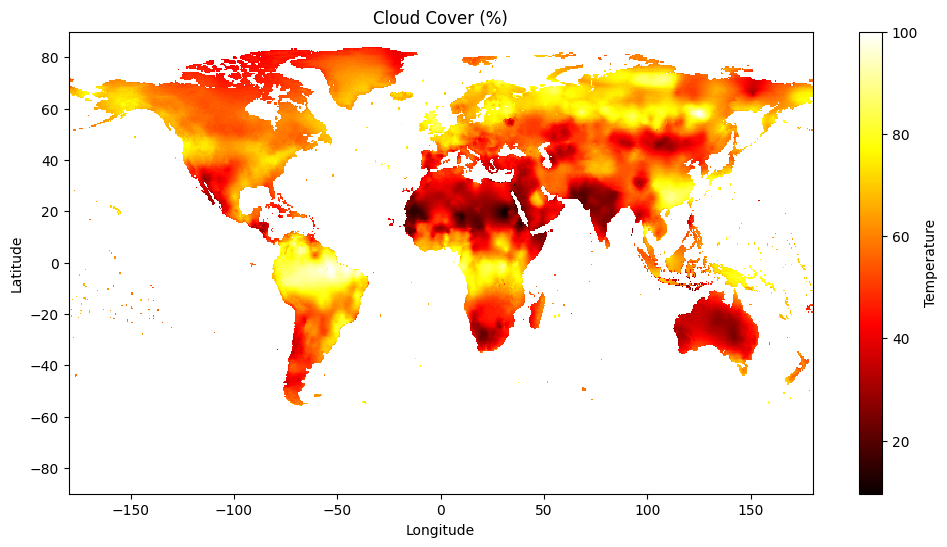

In [ ]:
_cld = ds_cld['cld'].values[-9]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, _cld, shading='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

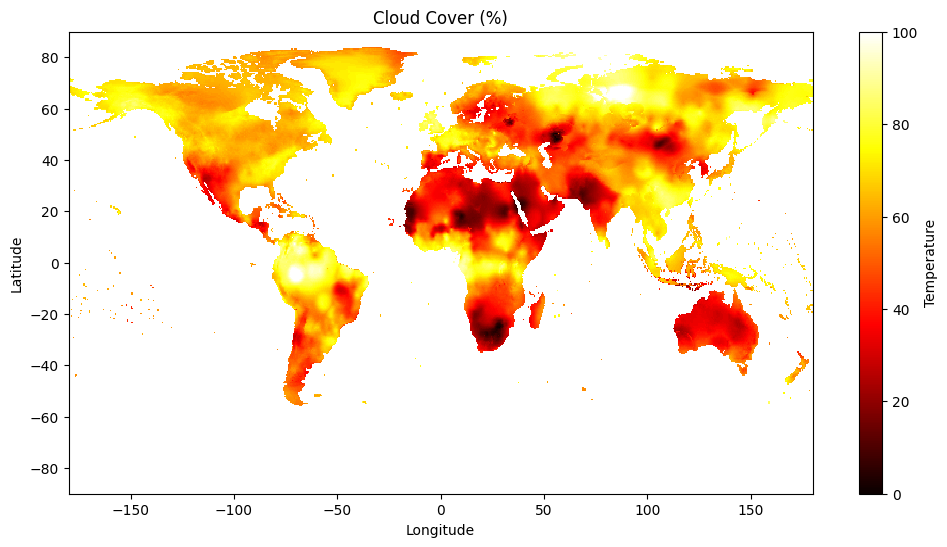

In [ ]:
_cld = ds_cld['cld'].values[-8]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, _cld, shading='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

In [68]:
# Perú parece estar en los rangos (google maps ayudó con esto):
min_lon = -81
max_lon = -68
min_lat = -18
max_lat = 0

In [69]:
rango_index_lon = np.where(
    (ds_cld['lon'].values >= min_lon)&
    (ds_cld['lon'].values <= max_lon)
                           )[0]
desde_index_lon = rango_index_lon[0]
hasta_index_lon = rango_index_lon[-1]

rango_index_lat = np.where(
    (ds_cld['lat'].values >= min_lat)&
    (ds_cld['lat'].values <= max_lat)
                           )[0]
desde_index_lat = rango_index_lat[0]
hasta_index_lat = rango_index_lat[-1]



In [70]:
_lon, _lat = np.meshgrid(ds_cld['lon'].values[desde_index_lon:hasta_index_lon+1], ds_cld['lat'].values[desde_index_lat:hasta_index_lat+1])
datos_cld = ds_cld['cld'].values[-8][desde_index_lat:hasta_index_lat+1, desde_index_lon:hasta_index_lon+1]

In [72]:
datos_cld.shape

(36, 26)

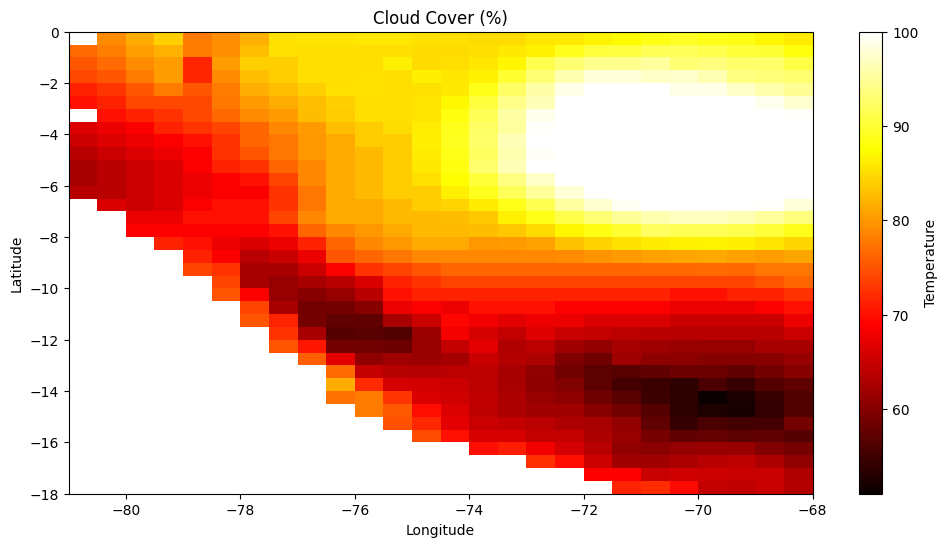

In [71]:

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, datos_cld, shading='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

# Acotamiento a Perú

In [73]:
def filtrar_por_lat_lon(ds, lat_range, lon_range):
    """
    Filtra el dataset por un rango de latitudes y longitudes.
    
    Args:
        ds (xarray.Dataset): Dataset a filtrar.
        lat_range (tuple): Rango de latitudes (min_lat, max_lat).
        lon_range (tuple): Rango de longitudes (min_lon, max_lon).
        
    Returns:
        xarray.Dataset: Dataset filtrado.
    """
    return ds.sel(lat=slice(*lat_range), lon=slice(*lon_range))

In [74]:
ds_cld_peru = filtrar_por_lat_lon(ds_cld, (min_lat, max_lat), (min_lon, max_lon))

In [75]:
ds_cld_peru

<xarray.Dataset> Size: 28MB
Dimensions:  (lon: 26, lat: 36, time: 1488)
Coordinates:
  * lon      (lon) float32 104B -80.75 -80.25 -79.75 ... -69.25 -68.75 -68.25
  * lat      (lat) float32 144B -17.75 -17.25 -16.75 ... -1.25 -0.75 -0.25
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Data variables:
    cld      (time, lat, lon) float32 6MB nan nan nan nan ... 96.7 97.9 99.7
    stn      (time, lat, lon) float64 11MB ...
    mae      (time, lat, lon) float32 6MB ...
    maea     (time, lat, lon) float32 6MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Cloud Cover
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:cld.2503051121.dtb...
    history:      Wed  5 Mar 20:16:29 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [ ]:
files_cargados_peru  = {info:filtrar_por_lat_lon(files_cargados[info], (min_lat, max_lat), (min_lon, max_lon)) for info in files_cargados}

# Transform data into a GraphFormat

In [86]:
files_cargados_peru.keys()

dict_keys(['ds_cld', 'ds_dtr', 'ds_frs', 'ds_pet', 'ds_pre', 'ds_tmn', 'ds_tmp', 'ds_tmx', 'ds_vap', 'ds_wet'])

In [123]:
las_lon = np.array([files_cargados_peru[el_ds]['lon'].values for el_ds in files_cargados_peru])
las_lat = np.array([files_cargados_peru[el_ds]['lat'].values for el_ds in files_cargados_peru])
los_mes = np.array([files_cargados_peru[el_ds]['time'].values for el_ds in files_cargados_peru])

In [88]:
np.max( np.min(las_lon, axis=0) == np.max(las_lon, axis=0)   )
# Todas las lon son iguales en todos los datasets (El máx es True)

np.True_

In [89]:
np.max( np.min(las_lat, axis=0) == np.max(las_lat, axis=0)   )
# Todas las lat son iguales en todos los datasets (El máx es True)

np.True_

In [125]:
np.max( np.min(los_mes, axis=0) == np.max(los_mes, axis=0)   )
# Todas los meses son iguales en todos los datasets (El máx es True)

np.True_

In [ ]:
_las_lon, _las_lat, _los_mes = np.meshgrid(las_lon[0], las_lat[0], los_mes[0])
lon_for_df = _las_lon.ravel()
lat_for_df = _las_lat.ravel()
mese_for_df = _los_mes.ravel()

consol_df = pd.DataFrame({'time': mese_for_df,
                'lon':lon_for_df,
                'lat':lat_for_df})

for info in files_cargados_peru:
    info_name = re.sub(r'ds_', '', info)
    tmp_df = pd.DataFrame(
                {'time': mese_for_df,
                'lon':lon_for_df,
                'lat':lat_for_df,
                info_name: files_cargados_peru[info][info_name].values.ravel()
                })
    consol_df = pd.concat([consol_df, tmp_df[[info_name]]], axis=1)
    

In [122]:
files_cargados_peru[info]

<xarray.Dataset> Size: 33MB
Dimensions:  (lon: 26, lat: 36, time: 1488)
Coordinates:
  * lon      (lon) float32 104B -80.75 -80.25 -79.75 ... -69.25 -68.75 -68.25
  * lat      (lat) float32 144B -17.75 -17.25 -16.75 ... -1.25 -0.75 -0.25
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Data variables:
    wet      (time, lat, lon) timedelta64[ns] 11MB NaT ... 23 days 07:40:47.9...
    stn      (time, lat, lon) float64 11MB ...
    mae      (time, lat, lon) float32 6MB ...
    maea     (time, lat, lon) float32 6MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Rain Days
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:wet.2503051121.dtb...
    history:      Wed  5 Mar 17:51:19 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [138]:
consol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392768 entries, 0 to 1392767
Data columns (total 13 columns):
 #   Column  Non-Null Count    Dtype          
---  ------  --------------    -----          
 0   time    1392768 non-null  datetime64[ns] 
 1   lon     1392768 non-null  float32        
 2   lat     1392768 non-null  float32        
 3   cld     1111536 non-null  float32        
 4   dtr     1111536 non-null  float32        
 5   frs     1111536 non-null  timedelta64[ns]
 6   pet     1108560 non-null  float32        
 7   pre     1111536 non-null  float32        
 8   tmn     1111536 non-null  float32        
 9   tmp     1111536 non-null  float32        
 10  tmx     1111536 non-null  float32        
 11  vap     1111536 non-null  float32        
 12  wet     1111536 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float32(10), timedelta64[ns](2)
memory usage: 85.0 MB


In [139]:
consol_df.sample(10)

,time,lon,lat,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet
359916,2010-01-16,-77.25,-13.25,88.800003,11.000000,0 days 00:00:00,2.8,150.000000,20.100000,25.600000,31.100000,28.300001,16 days 11:02:23.920898437
103287,1952-04-16,-72.25,-16.75,79.300003,10.400001,0 days 00:00:00,3.4,217.400009,19.100000,24.300001,29.500000,21.700001,13 days 19:40:47.973632812
147869,1947-06-16,-70.25,-16.25,81.300003,10.500000,0 days 00:00:00,2.9,258.200012,18.200001,23.400000,28.700001,25.000000,18 days 18:57:35.914306640
726566,1936-03-16,-70.75,-8.75,53.700001,14.700000,0 days 00:00:00,4.3,111.200005,13.600000,20.900000,28.300001,14.700000,6 days 19:11:59.975280761
1298448,1977-01-16,-73.75,-1.25,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT
343797,1906-10-16,-69.25,-13.75,51.299999,13.600000,0 days 00:00:00,4.0,47.700001,18.800001,25.600000,32.400002,22.500000,2 days 19:26:23.995056152
1021588,1969-05-16,-75.75,-4.75,81.599998,9.300000,0 days 00:00:00,3.3,166.100006,22.100000,26.700001,31.400000,27.600000,13 days 23:02:24.003295898
294992,1931-09-16,-72.75,-14.25,59.700001,15.600000,14 days 12:14:23.937377929,2.8,47.200001,1.100000,8.900001,16.700001,7.300000,7 days 23:16:47.981872558
803233,2001-02-15,-71.25,-7.75,40.000000,17.400000,23 days 02:09:36.013183593,3.0,4.800000,-2.100000,6.600000,15.300000,4.900000,1 days 00:28:47.998352050
1221893,1921-06-16,-73.25,-2.25,60.100002,11.200000,0 days 00:00:00,4.0,162.500000,21.200001,26.800001,32.400002,27.000000,8 days 21:50:23.986816406


In [140]:
consol_df.to_csv(el_path_main/'2. Datos/Main gridded data/consol_df_peru.csv', index=False)